In [6]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Parameters

In [8]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
pickles_dir = f'{engram_dir}pickles/pnet_denoising/'
file_prefix = 'pearsonr'

In [9]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Load Results

In [39]:
max_scores = {}
results = {
    'popln_shuffle': [], 'popln_timestep': [],
    'popln_sim': [], 'popln_layer': [], 'valid_score': [],
    'bg': [], 'snr': [], 'is_max': []}
for pickle_file in os.listdir(pickles_dir):
    if not pickle_file.startswith(file_prefix): continue
    noise_info = pickle_file.split('_')
    noise_bg = noise_info[1]
    noise_snr = float(noise_info[2][3:-2])
    with open(f'{pickles_dir}{pickle_file}', 'rb') as f:
        _results = pickle.load(f)
    for key in _results.keys():
        results[key].extend(_results[key])
    results['bg'].extend([noise_bg]*len(_results[key]))
    results['snr'].extend([noise_snr]*len(_results[key]))
    if 'bg' not in max_scores.keys():
        max_scores['bg'] = {}
    max_score = np.max(_results['valid_score'])
    max_scores['bg']['snr'] = max_score
    results['is_max'].extend([v==max_score for v in _results['valid_score']])
for key in results.keys():
    results[key] = np.array(results[key])

# Calculate extra measures

In [40]:
norm_popln_sim = results['popln_sim'].copy()
for t in np.unique(results['popln_timestep']):
    for l in np.unique(results['popln_layer']):
        idxs = np.logical_and(
            results['popln_timestep'] == t, results['popln_layer'] == l)
        mean_shuff = np.mean(results['popln_shuffle'][idxs])
        norm_popln_sim[idxs] /= mean_shuff
results['norm_popln_sim'] = norm_popln_sim

In [41]:
df = pd.DataFrame(results)

# Across Timesteps

In [42]:
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']

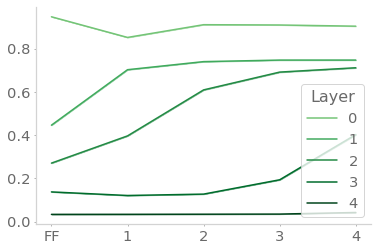

In [38]:
from scipy.stats import sem
import matplotlib.cm as cm

colors = cm.get_cmap('Greens')(np.linspace(0.5, 1., len(layers)))
ts = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
for layer_idx, layer in enumerate(layers):
    layer_means = []
    layer_sems = []
    for t in ts:
        vals = df[(df['popln_layer']==layer) & (df['popln_timestep']==t)]
        vals = vals['popln_shuffle']
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    ax.plot(
        ts, layer_means,
        label=layer_idx, color=colors[layer_idx]
        )
    ax.fill_between(
        ts, layer_means-layer_sems, layer_means+layer_sems,
        color=colors[layer_idx], alpha=0.4
        )
plt.legend(title='Layer')
plt.xticks([0,1,2,3,4], ['FF', '1', '2', '3', '4'])
plt.savefig('../figures/corrs.svg', dpi=300)
plt.show()


In [47]:
len(new_df['is_max'])

69552

In [46]:
np.sum(df['is_max'])

69552

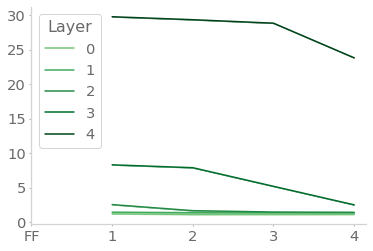

In [45]:
from scipy.stats import sem
import matplotlib.cm as cm

new_df = df.copy()
new_df = new_df[new_df['is_max']==True]
colors = cm.get_cmap('Greens')(np.linspace(0.5, 1., len(layers)))
ts = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
for layer_idx, layer in enumerate(layers):
    layer_means = []
    layer_sems = []
    for t in ts:
        vals = new_df[(new_df['popln_layer']==layer) & (new_df['popln_timestep']==t)]
        vals = vals['norm_popln_sim']
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    ax.plot(
        ts, layer_means,
        label=layer_idx, color=colors[layer_idx]
        )
    ax.fill_between(
        ts, layer_means-layer_sems, layer_means+layer_sems,
        color=colors[layer_idx], alpha=0.4
        )
plt.legend(title='Layer')
plt.xticks([0,1,2,3,4], ['FF', '1', '2', '3', '4'])
plt.savefig('../figures/corrs.svg', dpi=300)
plt.show()


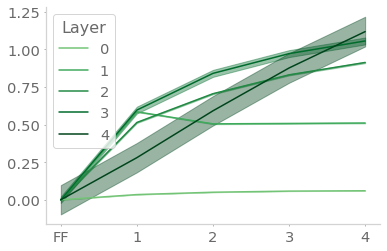

In [13]:
from scipy.stats import sem
import matplotlib.cm as cm

colors = cm.get_cmap('Greens')(np.linspace(0.5, 1., len(layers)))
ts = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
for layer_idx, layer in enumerate(layers):
    layer_means = []
    layer_sems = []
    for t in ts:
        vals = df[(df['layer']==layer) & (df['timestep']==t)]
        vals = vals['corr_norm_mean_sub']
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    ax.plot(
        ts, layer_means,
        label=layer_idx, color=colors[layer_idx]
        )
    ax.fill_between(
        ts, layer_means-layer_sems, layer_means+layer_sems,
        color=colors[layer_idx], alpha=0.4
        )
plt.legend(title='Layer')
plt.xticks([0,1,2,3,4], ['FF', '1', '2', '3', '4'])
plt.savefig('../figures/corrs.svg', dpi=300)
plt.show()


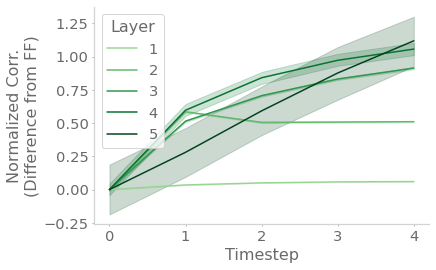

In [162]:
import matplotlib.cm as cm
colors = cm.get_cmap('Greens')(np.linspace(0.4, 1., len(layers)))
fig, ax = plt.subplots()
for i, layer in enumerate(layers):
    sns.lineplot(
        x='timestep', y='corr_norm_mean_sub',
        data=df[df['layer']==layer],
        color=colors[i], label=i+1
        )
plt.ylabel('Normalized Corr.\n(Difference from FF)')
plt.xlabel('Timestep')
plt.legend(title='Layer')

# By noise type

<AxesSubplot:xlabel='timestep', ylabel='corr_norm'>

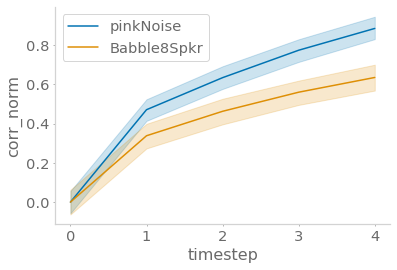

In [109]:
fig, ax = plt.subplots()
offset_df = df[df['bg']=='pinkNoise'].copy()
for l in layers:
    offset_df['corr_norm'][df['layer'] == l] -= np.mean(
        offset_df['corr_norm'][
            (df['timestep']==0.) & (df['layer'] == l)
            ]
        )
sns.lineplot(
    x='timestep', y='corr_norm',
    data=offset_df,
    hue_order=layers, ax=ax, label='pinkNoise'
    )

offset_df = df[df['bg']=='Babble8Spkr'].copy()
for l in layers:
    offset_df['corr_norm'][df['layer'] == l] -= np.mean(
        offset_df['corr_norm'][
            (df['timestep']==0.) & (df['layer'] == l)
            ]
        )
sns.lineplot(
    x='timestep', y='corr_norm',
    data=offset_df,
    hue_order=layers, label='Babble8Spkr', ax=ax
    )

# By SNR

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


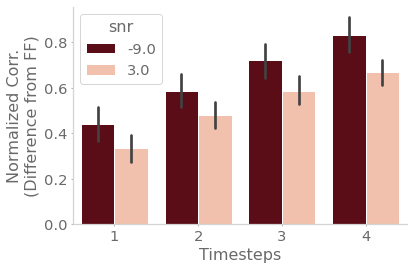

In [12]:
fig, ax = plt.subplots()
import matplotlib.cm as cm
colors = cm.get_cmap('Reds_r')(np.linspace(0., 0.75, 5))
offset_df = df.copy()
for snr in [-9., 3.]:
    for l in layers:
        offset_df['corr_norm'][(df['layer'] == l) & (df['snr']==snr)] -= np.mean(
            offset_df['corr_norm'][
                (df['timestep']==0.) & (df['layer'] == l) & (df['snr']==snr)
                ]
            )
offset_df = offset_df[(df['snr']==-9.) | (df['snr']==3.)]
g = sns.barplot(
    x='timestep', y='corr_norm',
    data=offset_df[offset_df['timestep']!=0],
    hue='snr', ax=ax, palette=[colors[0], colors[-1]]
    )
#g.legend_.remove()
ax.set_ylabel('Normalized Corr.\n(Difference from FF)')
ax.set_xlabel('Timesteps')
plt.savefig('corr_snr.svg', dpi=300)

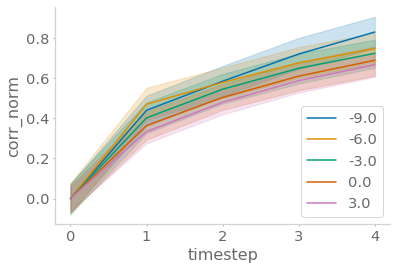

In [114]:
fig, ax = plt.subplots()
for snr in [-9., -6., -3., 0., 3.]:
    offset_df = df[df['snr']==snr].copy()
    for l in layers:
        offset_df['corr_norm'][df['layer'] == l] -= np.mean(
            offset_df['corr_norm'][
                (df['timestep']==0.) & (df['layer'] == l)
                ]
            )
    sns.lineplot(
        x='timestep', y='corr_norm',
        data=offset_df,
        hue_order=layers, ax=ax, label=snr
        )

# Across Layers

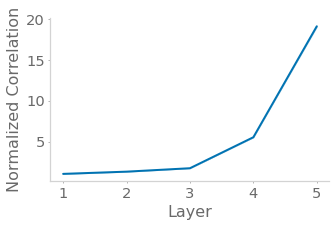

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    x='layer', y='corr_norm',
    data=df, color='C0', linewidth=2, ax=ax
    )
plt.ylabel('Normalized Correlation')
plt.xlabel('Layer')
ax.set_xticklabels([1,2,3,4,5])
plt.savefig('corr_layers.svg', dpi=300)